Data augmentation is one of the major techniques used when we want to improve the model's performance on new data (i.e. generalization). It is especially useful in cases where only limited training data are available. In this post we'll discuss some of the augmentation techniques (besides affine transformation) that help the models to perform well (in computer vision).

In [1]:
# install required libraries
# !pip install opencv-python==4.5.1.48
# !pip install numpy==1.21.0
# !pip install matplotlib==3.4.2

In [2]:
# import the required libraries
from copy import deepcopy

import cv2
import matplotlib.pyplot as plt
import numpy as np

# set random seed to reproduce results
np.random.seed(42)

In [3]:
# define labels and read images

cat_label = np.array([[1, 0]])
dog_label = np.array([[0, 1]])

cat_img = cv2.imread("images/cat.jpg")/255.0
dog_img = cv2.imread("images/dog.jpg")/255.0

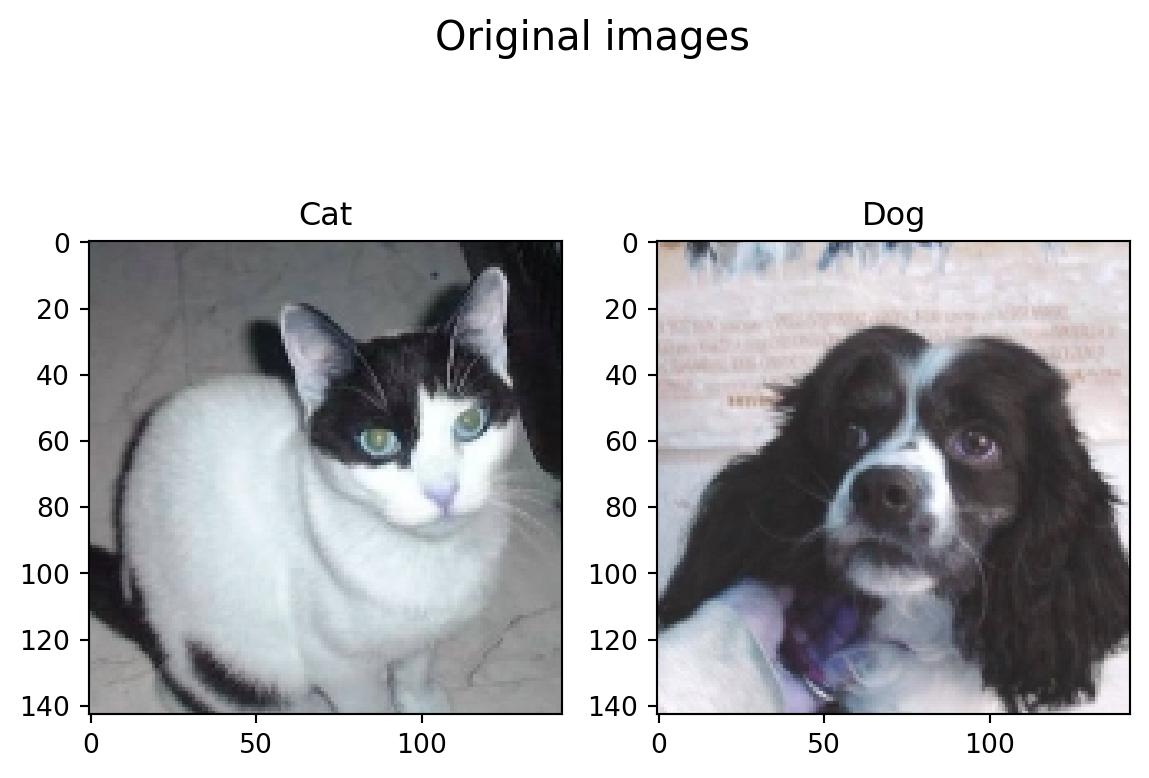

In [4]:
# plot the original images

fig, ((ax1, ax2)) = plt.subplots(1, 2)

ax1.imshow(cat_img)
ax1.set_title("Cat")

ax2.imshow(dog_img)
ax2.set_title("Dog")

plt.suptitle("Original images",fontsize=15)

plt.show()

# Cutout

[paper link](https://arxiv.org/abs/1708.04552)

The main motivation of Cutout is to simulate the situation of object occlusion that is mostly encountered in tasks such as object recognition or human pose estimation. We occlude the part of image randomly. Instead of model seeing the same image everytime, it sees different parts of that image which helps it to perform well. The occluded part does not contain any information. In the example below, the randomly occluded part is replaced by all 0s.

In [5]:
class Cutout(object):
    def __init__(self, cutout_width):
        # width of the square to occlude
        self.cutout_width = cutout_width

    def __call__(self, img):
        h = img.shape[0]
        w = img.shape[1]

        mask = np.ones(img.shape)

        y = np.random.randint(h)
        x = np.random.randint(w)

        x1 = np.clip(x - self.cutout_width // 2, 0, w)
        x2 = np.clip(x + self.cutout_width // 2, 0, w)

        y1 = np.clip(y - self.cutout_width // 2, 0, h)
        y2 = np.clip(y + self.cutout_width // 2, 0, h)

        mask[y1: y2, x1: x2] = 0.0

        # occlude the part of image using mask (zero out the part)
        img = img * mask

        return img

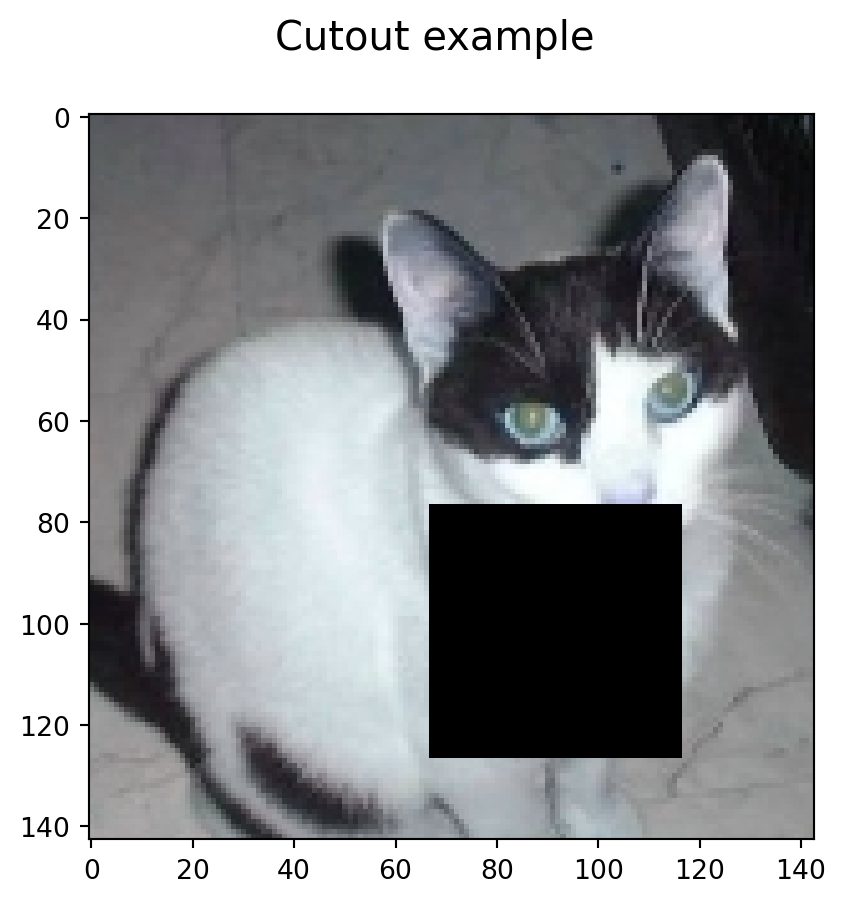

In [6]:
cutout = Cutout(50)
plt.imshow(cutout(cat_img))
plt.suptitle("Cutout example",fontsize=15)

plt.show()

# Mixup
[paper link](https://arxiv.org/abs/1710.09412)

Mixup linearly mixes two images and their labels in the same proportion. With this approach the model will be able to see a different image with different label during training. It enables the model to make smooth decision boundaries while classifying the object since we are using linearly interpolated images and labels for classification decision intead of binary decision. As can be seen in the example below, with the mixup of images and labels, the new image will have the labels `[0.19, 0.81]` which means the class distribution is tilted more towards dog and the mixup visualization also proves this.

In [7]:
class Mixup:
    def __init__(self, img1, img2, label1, label2):
        self.img1 = img1
        self.img2 = img2
        self.label1 = label1
        self.label2 = label2
    
    def __call__(self):
        alpha = 1
        lam = np.random.beta(alpha, alpha)
        
        # mix image and labels        
        mix_img = lam * self.img1 + (1 - lam) * self.img2
        mix_label = lam * self.label1 + (1 - lam) * self.label2
        
        return mix_img, mix_label

In [8]:
mix_img, mix_label = Mixup(cat_img, dog_img, cat_label, dog_label)()

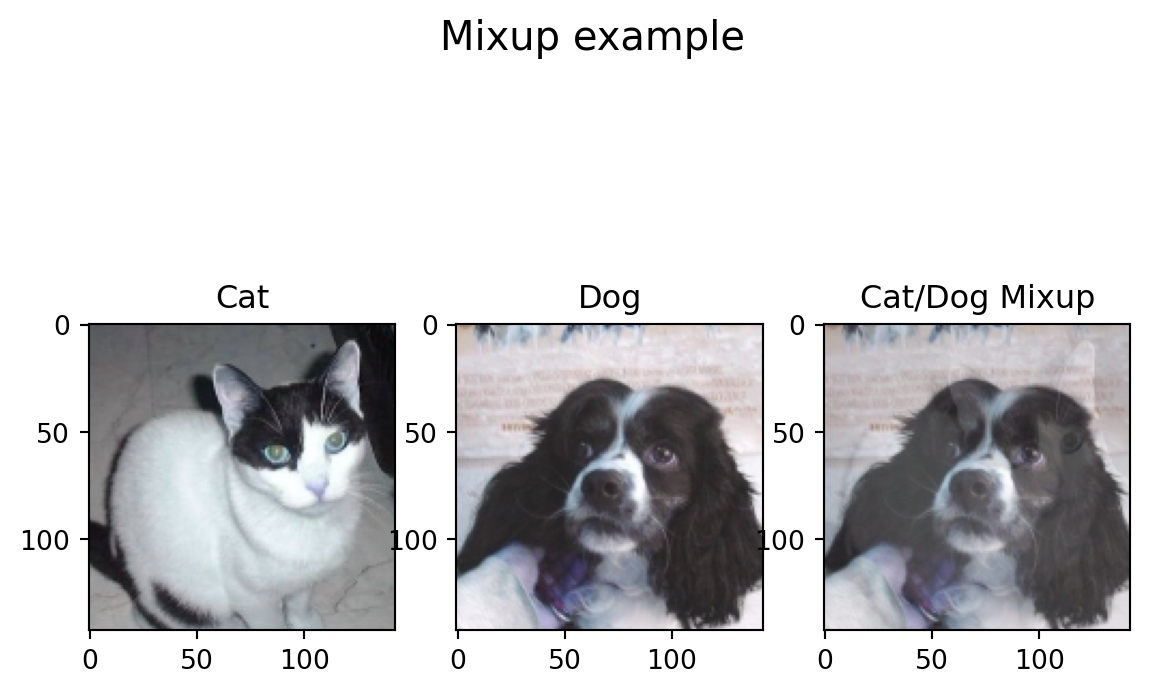

In [9]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

ax1.imshow(cat_img)
ax1.set_title("Cat")

ax2.imshow(dog_img)
ax2.set_title("Dog")

ax3.imshow(mix_img)
ax3.set_title("Cat/Dog Mixup")
plt.suptitle("Mixup example",fontsize=15)

plt.show()

# Cutmix
[paper link](https://arxiv.org/abs/1905.04899)

As we saw above, the occluded part in Cutout does not contain any information which in unwanted since it just increases resource usage without adding any value. Cutmix utilizes above two techniques to mix the images and utilize the occluded part. As can be seen in the example, the cutout portion in dog image is replaced by the same portion of cat image. It also linearly interpolates the label as in Mixup. As seen in the example below, the new labels are `[0.18, 0.82]` for cat and dog respectively and this can be verified from image as well.

In [10]:
class Cutmix:
    def __init__(self, img1, img2, lbl1, lbl2):
        self.img1 = img1
        self.img2 = img2
        self.lbl1 = lbl1
        self.lbl2 = lbl2
    
    def __call__(self):
        # sample bounding box B
        alpha = 1
        lam = np.random.beta(alpha, alpha)
        h, w, c = self.img1.shape
        
        r_x = np.random.randint(0, w)
        r_y = np.random.randint(0, h)
        r_w = np.int32(w * np.sqrt(1 - lam))
        r_h = np.int32(h * np.sqrt(1 - lam))
        
        mid_x, mid_y = r_w//2, r_h//2
        
        point1_x = np.clip(r_x - mid_x, 0, w)
        point2_x = np.clip(r_x + mid_x, 0, w)
        
        point1_y = np.clip(r_y - mid_y, 0, h)
        point2_y = np.clip(r_y + mid_y, 0, h)
        
        # refer to paper to see how M is cimputed, in short it is to make the ratio of mixing images and labels same
        M = np.ones(self.img1.shape)
        M[point1_x:point2_x, point1_y:point2_y, :] = 0
        
        cut_mix_img = M * self.img1 + (1 - M) * self.img2
        cut_mix_label = lam * self.lbl1 + (1 - lam) * self.lbl2
        
        return cut_mix_img, cut_mix_label

In [11]:
cut_mix_img, cut_mix_lbl = Cutmix(cat_img, dog_img, cat_label, dog_label)()

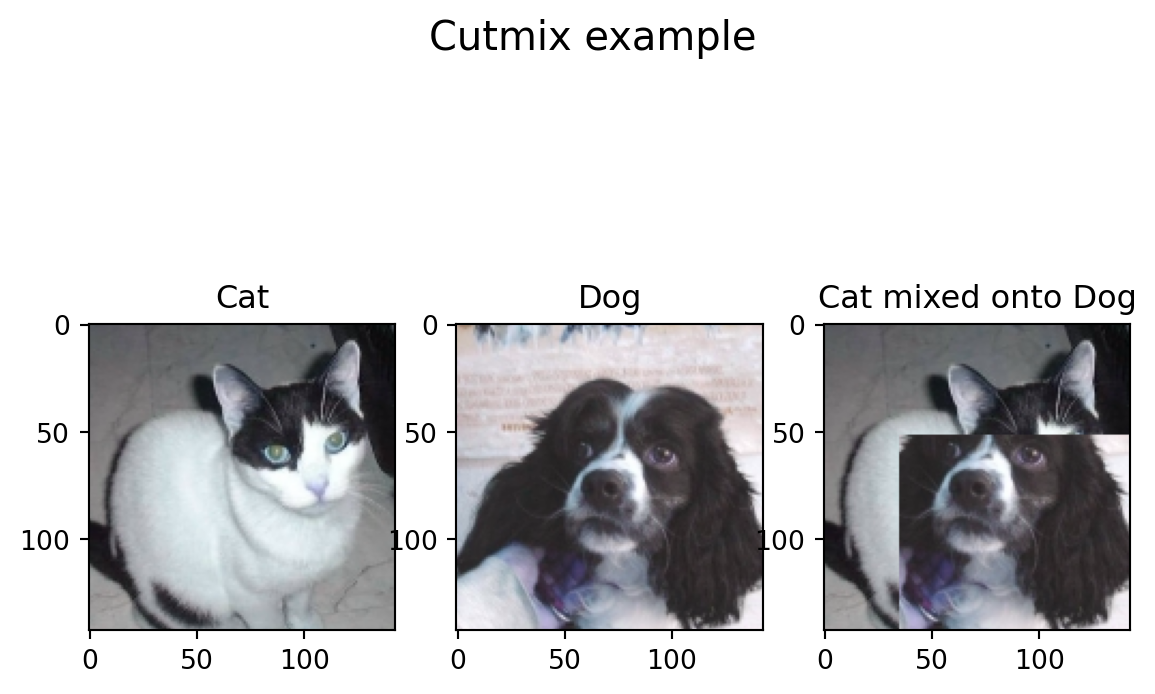

In [12]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

ax1.imshow(cat_img)
ax1.set_title("Cat")

ax2.imshow(dog_img)
ax2.set_title("Dog")

ax3.imshow(cut_mix_img)
ax3.set_title("Cat mixed onto Dog")
plt.suptitle("Cutmix example", fontsize=15)

plt.show()

# Label Smoothing

[paper link](https://arxiv.org/abs/1512.00567)

Label smoothing is used so that the model can be prevented from memorizing the training data and being over-confident. It adds noise to the labels without modifying the data itself. If we are using a 5-class classifier then instead of label being assigned only to one class, it is distributed among all the classes. As seen in example below, $\epsilon$ is used to control the smoothing.

In [13]:
ϵ = 0.01
num_labels = 5
classes = ["cat", "dog", "horse", "bus", "carrot"]

original_label = [1, 0, 0, 0, 0]
new_neg_labels = ϵ/(num_labels-1)

# after label smoothing, cat gets 1 - ϵ and other classes get ϵ/(1-ϵ) probability
smooth_labels = [1 - ϵ, new_neg_labels, new_neg_labels, new_neg_labels, new_neg_labels]

smooth_labels

[0.99, 0.0025, 0.0025, 0.0025, 0.0025]

All the above implementations assume that both the images are of same resolution. There might be some minor differences while compared with the original paper. However the main motivation and results of these techniques are same to that of paper. Please feel free to post any comment, question or suggestion. I'll see you in the next one. :)